In [54]:
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
weather = pd.read_csv("C:/Users/MUZAM/Downloads/weatherdata.csv", index_col="Date")
weather.columns = weather.columns.str.lower()
weather = weather.ffill()
weather

,tavg,tmax,tmin,prcp
Date,,,,
01-01-1980,75,NaN,68.0,0.00
02-01-1980,74,84.0,66.0,0.00
03-01-1980,76,84.0,66.0,0.00
04-01-1980,76,86.0,68.0,0.00
05-01-1980,77,84.0,70.0,0.00
...,...,...,...,...
28-06-2023,90,96.0,82.0,0.00
29-06-2023,88,99.0,82.0,0.00
30-06-2023,89,100.0,80.0,0.04


In [56]:
weather = weather.ffill()
weather.index = pd.to_datetime(weather.index)
weather.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2023-06-23', '2023-06-24', '2023-06-25', '2023-06-26',
               '2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30',
               '2023-01-07', '2023-02-07'],
              dtype='datetime64[ns]', name='Date', length=15832, freq=None)

In [57]:
weather["target"]=weather.shift(-1)["tmin"]
weather

,tavg,tmax,tmin,prcp,target
Date,,,,,
1980-01-01,75,NaN,68.0,0.00,66.0
1980-02-01,74,84.0,66.0,0.00,66.0
1980-03-01,76,84.0,66.0,0.00,68.0
1980-04-01,76,86.0,68.0,0.00,70.0
1980-05-01,77,84.0,70.0,0.00,72.0
...,...,...,...,...,...
2023-06-28,90,96.0,82.0,0.00,82.0
2023-06-29,88,99.0,82.0,0.00,80.0
2023-06-30,89,100.0,80.0,0.04,82.0


In [58]:
weather = weather.fillna(weather.mean())
weather

,tavg,tmax,tmin,prcp,target
Date,,,,,
1980-01-01,75,92.700335,68.0,0.00,66.000000
1980-02-01,74,84.000000,66.0,0.00,66.000000
1980-03-01,76,84.000000,66.0,0.00,68.000000
1980-04-01,76,86.000000,68.0,0.00,70.000000
1980-05-01,77,84.000000,70.0,0.00,72.000000
...,...,...,...,...,...
2023-06-28,90,96.000000,82.0,0.00,82.000000
2023-06-29,88,99.000000,82.0,0.00,80.000000
2023-06-30,89,100.000000,80.0,0.04,82.000000


In [59]:
predictors = weather.columns[~weather.columns.isin(["target"])]
predictions = backtest(weather, model, predictors)

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
model = LinearRegression()

In [61]:
def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]
        model.fit(train[predictors], train["target"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [62]:
predictors = weather.columns[~weather.columns.isin(["target"])]
predictions = backtest(weather, model, predictors)

In [63]:
r2 = model.score(weather[predictors], weather["target"])
print("R-squared:", r2)

R-squared: 0.8583193942068422


In [64]:
mae = mean_absolute_error(predictions["actual"], predictions["prediction"])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 1.2763212289896118


In [65]:
mse = mean_squared_error(predictions["actual"], predictions["prediction"])
print("Mean Squared Error:", mse)


Mean Squared Error: 3.1372177329631654


In [66]:
predictions.sort_values("diff", ascending=False)

,actual,prediction,diff
Date,,,
2002-06-01,54.0,73.439881,19.439881
2009-05-13,71.0,83.200945,12.200945
1996-04-30,71.0,82.512297,11.512297
1993-05-26,73.0,83.436181,10.436181
2017-06-07,70.0,80.259066,10.259066
...,...,...,...
2018-01-24,69.0,69.000602,0.000602
2010-07-29,76.0,75.999404,0.000596
2020-03-11,77.0,77.000283,0.000283


In [67]:
def pct_diff(old, new):
    return (new - old) / old

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"
    weather[label] = weather[col].rolling(horizon).mean()
    weather[f"{label}_pct"] = pct_diff(weather[label], weather[col])
    return weather
    
rolling_horizons = [3, 14]
for horizon in rolling_horizons:
    for col in ["tmax ", "tmin", "prcp "]:
        weather = compute_rolling(weather, horizon, col)

In [68]:
def expand_mean(df):
    return df.expanding(1).mean()

for col in ["tmax ", "tmin", "prcp "]:
    weather[f"month_avg_{col}"] = weather[col].groupby(weather.index.month, group_keys=False).apply(expand_mean)
    weather[f"day_avg_{col}"] = weather[col].groupby(weather.index.day_of_year, group_keys=False).apply(expand_mean)

In [69]:
weather = weather.iloc[14:,:]
weather = weather.fillna(0)

In [70]:
predictors = weather.columns[~weather.columns.isin(["target"])]

In [71]:
predictions = backtest(weather, model, predictors)
mean_absolute_error(predictions["actual"], predictions["prediction"])

1.2519149090724988

In [72]:
r2 = model.score(weather[predictors], weather["target"])
print("R-squared:", r2)

R-squared: 0.8638799906341166


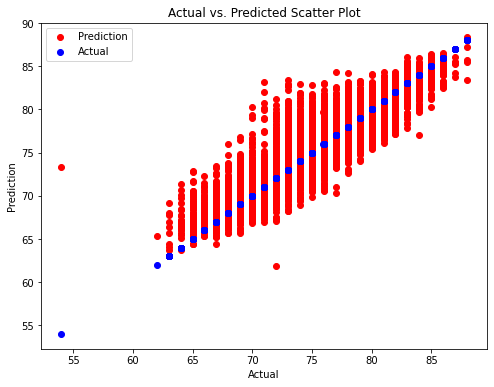

In [73]:
plt.figure(figsize=(8, 6))
plt.scatter(predictions["actual"], predictions["prediction"], color="red", label="Prediction")
plt.scatter(predictions["actual"], predictions["actual"], color="blue", label="Actual")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Actual vs. Predicted Scatter Plot")
plt.legend()
plt.show()